> PHYS667 Homework 10, assignment by F. Bianco
> 
> Responses by **Shea Fitzgerald**

#0: Importing Data

In [2]:
import numpy as np
import pandas as pd
import pylab as pl
import sklearn as skl
import scipy as sp
from sklearn import cluster
!pip3 install corner
import corner
from scipy.cluster.hierarchy import dendrogram, linkage
%pylab inline

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11643 sha256=c3797ed4a922b6738d0eaf038d7dd4d5f1262052454df8392f96d9a1d690dd92
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner
Populating the interactive namespace from numpy and matplotlib


In [3]:
genes = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS/master/HW10/kidpackgenes.csv", index_col=0)
genes

,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,55,56,57,58,60,61,64,65,66,68,69,72,73,74,75,76,77,78,79,81,83,84,85,86,87
1,-0.146342,-0.520637,0.175828,-0.323736,0.172691,0.025156,0.024812,0.172268,0.207188,0.026710,0.370241,0.390749,-0.103504,0.100439,-0.375930,0.277828,-0.130996,-0.009923,-0.399163,-0.127337,0.234942,0.628659,0.032232,-0.051522,0.322164,0.677058,0.626976,-0.075533,0.105881,0.121000,0.544208,0.126653,0.214285,0.426416,-0.385641,0.018007,0.407190,-0.175330,-0.033392,-0.056588,0.380069,0.247337,-0.160898,0.362272,0.190525,0.101010,1.280034,-0.137223,0.013790,0.284715,-0.080554,0.077708,0.071853,-0.225874,-0.148424,-0.104276,0.427028,0.331856,0.167732,-0.576949,0.007349,-0.002330,0.168953,-0.122312,0.240705,-0.347746,-0.001797,-0.260594,0.105968,0.110885,-0.006975,0.550118,0.118934,0.327248
2,-0.465767,0.155823,0.226344,-0.547542,0.041096,0.137012,0.102497,-0.034277,0.500871,0.005533,0.394116,0.474481,-0.004962,0.828600,-0.458895,0.002399,-0.237577,-0.135808,-0.470168,0.088704,-0.039030,0.598749,0.216180,-0.086335,0.509942,0.741002,0.819442,-0.287630,0.253042,-0.122267,0.048518,0.164557,0.208869,0.351322,-0.096956,0.158479,0.566782,-0.171814,0.187912,0.103039,0.605204,-0.010693,0.145773,0.431635,0.408843,0.049612,0.873300,-0.445282,0.050207,0.102510,-0.438553,-0.000697,-0.232677,-0.684507,-0.138210,-0.265029,0.036734,0.474339,0.096666,-0.672424,-0.022295,0.094897,-0.123030,-0.382857,0.371435,-0.447105,-0.134904,-0.250699,0.164698,-0.035022,0.250384,0.463746,-0.514230,0.200956
3,-0.088964,-0.208241,-0.151039,-0.288229,-0.425568,0.121006,-0.097883,-0.007597,0.329636,-0.222495,0.102853,0.078648,-0.175050,0.064488,-0.243920,-0.036435,-0.815732,-0.094098,-0.786828,-0.497140,-0.211386,0.249518,0.195911,-0.136115,-0.079168,0.461258,0.268629,0.075221,0.447445,-0.380212,-0.127944,-0.514944,0.204084,-0.132934,-0.717559,-0.723766,-0.009187,-0.026201,-0.428314,-0.243215,0.017108,0.199045,0.335860,-0.070557,0.296754,-0.147136,0.479280,-0.445308,0.173236,0.198668,-0.086679,-0.161494,0.043638,-0.115692,-0.020515,-0.035825,0.120870,0.474513,0.061214,-1.124604,0.085298,-0.160597,-0.223782,0.135259,-0.014990,-0.458297,-0.050852,-0.168500,0.078716,-0.032231,-0.116947,-0.199880,-0.415793,-0.032004
4,-0.327696,-1.714948,0.068710,-0.168257,-0.471577,0.279013,-0.060734,-0.222574,0.658097,0.129876,0.531540,-0.109510,-0.178851,0.007126,-0.341273,-0.601923,-0.239953,0.307493,-0.264719,-0.105008,0.587365,0.220183,-0.380904,0.073614,0.082134,0.554048,0.300248,0.479317,0.110226,0.060817,0.080991,-0.165642,-0.327310,0.542784,-0.053313,-0.447296,0.701035,0.282916,0.272387,-0.124356,-0.091246,0.121123,-0.091694,0.174790,0.327808,1.024205,0.471022,0.087155,0.398634,-0.053726,0.354639,0.034264,0.684986,0.314253,0.181046,-0.273637,0.234412,0.066505,0.104653,-0.230860,0.074711,0.066029,0.276241,-0.331959,0.153765,-0.140409,-0.119515,-0.289881,0.944493,-0.142710,-1.119866,-0.215536,0.345946,0.056442
5,-0.092327,-0.660456,0.075948,-0.646501,-0.046137,-0.010305,0.368476,-0.043832,-0.321060,0.116657,0.345860,0.282539,-0.077624,0.826049,-0.136295,-0.686548,-0.580715,0.037365,-0.106896,0.196168,0.201661,0.180436,0.052139,-0.001053,0.152552,0.365342,0.462115,-0.155553,0.239003,-0.231050,0.629987,0.020532,0.063029,-0.981387,-0.280845,-0.164185,0.846567,-0.399580,0.340091,0.044768,0.334025,0.032647,0.466371,-0.118516,0.665676,0.443797,0.474259,-0.349966,0.100411,-0.265844,-0.333114,0.914200,-0.088706,-0.457485,-0.046669,0.171069,0.127423,0.483766,0.607528,-1.412080,-0.281975,0.080899,0.855141,-0.487761,-0.033032,0.394082,0.173515,-0.194819,0.149131,-0.097285,-0.288192,-0.491920,-0.722120,0.055477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

# 1: Brief Data Exploration

In [164]:
print('The means of the first and last few rows:\n',
      genes.mean(),"\n\n and the distribution of the means is\n{:0.4f}±{:0.4f}"
      .format(genes.mean().mean(),
                                                  genes.mean().std()),
      '\n\n---\n\n The standard deviations of the first/last few are:\n',
      genes.std(), "\n\n and the distribution of the standard deviations is\n\
      {:0.4f}±{:0.4f}".format(genes.std().mean(), genes.std().std()))

The means of the first and last few rows:
 1    -0.094115
2    -0.027780
3    -0.001672
4    -0.110167
5    -0.047817
        ...   
83   -0.051150
84    0.004469
85   -0.001898
86   -0.143864
87   -0.002374
Length: 74, dtype: float64 

 and the distribution of the means is
-0.0396±0.0392 

---

 The standard deviations of the first/last few are:
 1     0.502677
2     0.340808
3     0.328042
4     0.692851
5     0.434918
        ...   
83    0.401593
84    0.479766
85    0.487669
86    0.532901
87    0.346003
Length: 74, dtype: float64 

 and the distribution of the standard deviations is
      0.4418±0.0779


From the above analysis we can see that, although the means have a wide distribution around zero, each feature has a similar standard deviation/spread.

# 2: Preprocessing

In [0]:
# scaling the data such that μ = 0 and σ = 1
genes_scaled = skl.preprocessing.scale(genes, with_mean=True, with_std=True,
                                       copy=True)

In [166]:
# checking the means and standard deviations
genes_scaled.mean(0).round(3)

array([ 0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,
       -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0., -0.,
       -0., -0.,  0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,
       -0., -0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0.,  0.,
        0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0., -0.,
        0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0.])

In [167]:
genes_scaled.std(0).round(3)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [0]:
# twodproj is an arbitrary 2-dimensional projection of the data. The x- and y-
# scales are perfectly meaningless.
twodproj = skl.manifold.TSNE(n_components=2,
                             random_state=173533).fit_transform(genes_scaled)

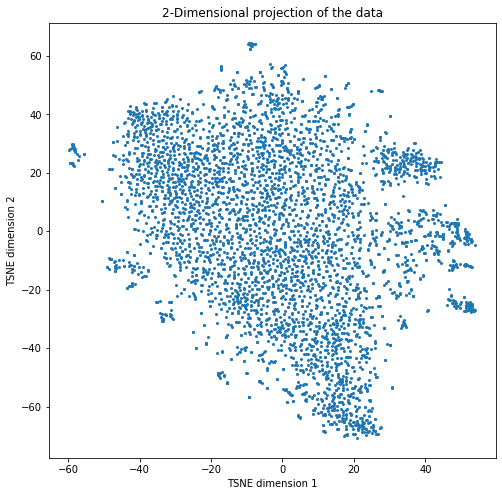

In [182]:
pl.figure(figsize = (8,8))
pl.plot(twodproj[:,0], twodproj[:,1], '.', markersize=4)
pl.title("2-Dimensional projection of the data");
pl.xlabel("TSNE dimension 1")
pl.ylabel("TSNE dimension 2")

None;

**Figure 1** An arbitrary 2-dimensional projection of the data. The x- and y-axes are mostly meaningless, apart from giving some reference as to the relative distance between points.

In [0]:
def CalICVar(X, labels):
    """
    This function *Cal*culates the *I*ntra-*C*luster *Var*iance, for a given
    array "X" assigned to clusters "labels" (labels should be the length of the
    number of datapoints in X, with a cluster assigned to each point)
    """
    icvar = 0
    for n in np.unique(labels):
        icvar += np.sum((X[labels == n] - X[labels == n].mean())**2)
    print(icvar)
    return icvar

# 3: K-Means Clustering

312576.00000000006
251076.64173410618
231187.35509465548
232349.62340001733
232254.43026077154
226430.7230903771
226441.1628461263
224422.23996599604
221420.12115044432
221740.75119761872


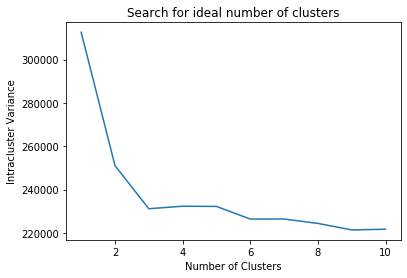

In [183]:
tv = []

np.random.seed(173900)

for i in range(1, 11):
    km = skl.cluster.k_means(genes_scaled, i)
    tv.append(CalICVar(genes_scaled, km[1]))
    
pl.plot(range(1,11), tv);
pl.title("Search for ideal number of clusters")
pl.xlabel("Number of Clusters")
pl.ylabel("Intracluster Variance")

None;

**Figure 2** Searching for an 'elbow' in the plot, indicating ideal number of clusters using the k-means algorithm. This process is often somewhat subjective, but in this case it seems fairly clear that 3-clusters is a good choice.

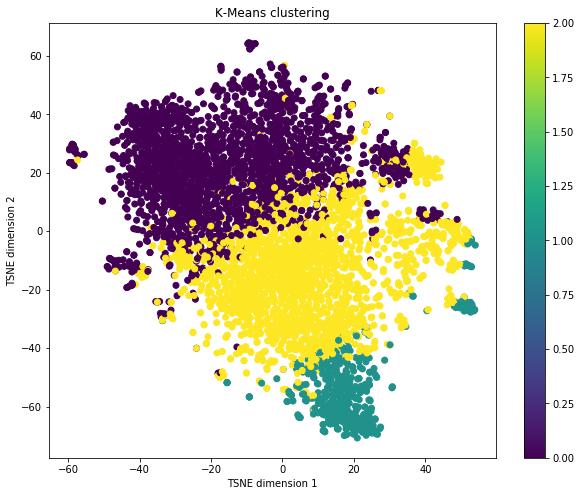

In [185]:
genes_kmclust = skl.cluster.KMeans(n_clusters = 3,
                                   random_state=174021).fit(genes_scaled)
pl.figure(figsize=(10,8))
pl.scatter(twodproj[:,0], twodproj[:,1], c=genes_kmclust.labels_)
pl.colorbar()
pl.title("K-Means clustering")
pl.xlabel("TSNE dimension 1")
pl.ylabel("TSNE dimension 2")


None;

**Figure 3** The same 2-dimensional projection of the dataset, clustered via k-means into 3 clusters.

# 4A: DBSCAN

## 4a1

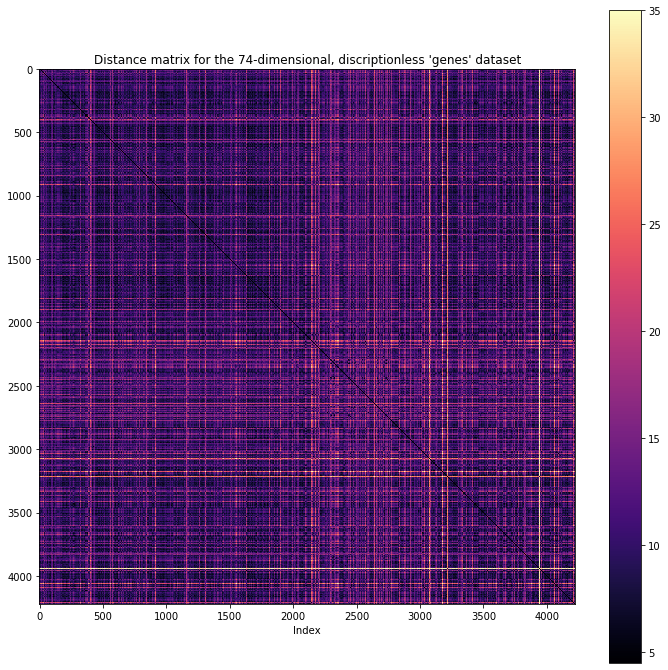

In [195]:
distance_mat = sp.spatial.distance.pdist(genes_scaled,
                                         metric = 'euclidean')

pl.figure(figsize = (12,12))

pl.imshow(sp.spatial.distance.squareform(distance_mat), cmap='magma', vmax=35,
          vmin=4.5)

pl.colorbar()

pl.title("Distance matrix for the 74-dimensional,\
 discriptionless 'genes' dataset")
pl.xlabel("Index")

None;

**Figure 4** The distance matrix for this dataset. Using figure 5, it was decided to cut the color-scaling at $4<d<35$, as nearly all the distances were in that range

<span style="color:red">**-2.5 pts: missing the question: is there structure?**</span>

## 4a2

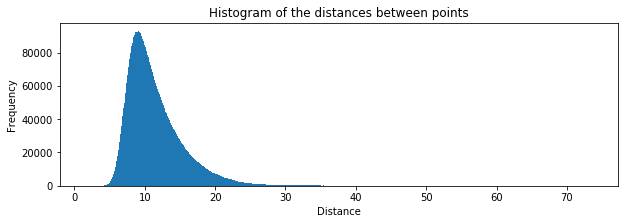

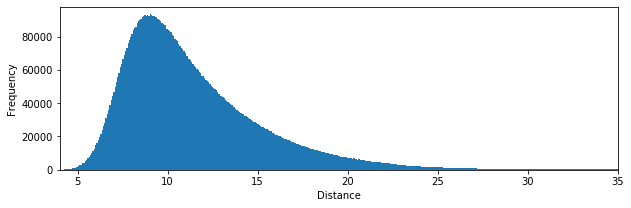

In [203]:
pl.figure(figsize = (10,3))
pl.hist(distance_mat, bins = 1000);
pl.title("Histogram of the distances between points")
pl.xlabel("Distance")
pl.ylabel("Frequency")
pl.show()

pl.figure(figsize = (10,3))
pl.hist(distance_mat, bins = 1000);
pl.xlim((4,35))
pl.xlabel("Distance")
pl.ylabel("Frequency")
pl.show()
None;

**Figure 5** Histogram of distances between points, showing a most common distance around 9 or 10 units, extrema near 0 and 75, and "effective" extrema around 4 and 35. (Essentially all distances are between 4 and 35)

In [15]:
distance_mat.mean()

11.470978212545768

## 4a3

In [0]:
# def customfitness(nclusters,nnoise,labels):
#     fitness = (nclusters-1)*nclusters * (len(labels) - nclusters)/(nnoise+1)**2*len(labels)
#     return(int(fitness))

In [0]:
# print('ee \t mm \t nclus \t nnoise')
# for ee in np.arange(5, 7, 0.05):
#     mm = 20

#     # dbs = skl.cluster.DBSCAN(eps=ee, min_samples=mm)
#     # dbs.fit(genes_scaled)
#     # # print(dbs.fit(genes_scaled))


#     # ##


#     # labels = dbs.labels_

#     # # Number of clusters in labels, ignoring noise if present.
#     # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     # n_noise_ = list(labels).count(-1)
#     # print(f'{ee:0.2f}', '\t', mm, '\t', n_clusters_, '\t',
#     #         n_noise_, '\t', customfitness(n_clusters_, n_noise_, labels))

In [0]:
dbs = skl.cluster.DBSCAN(eps=5.6, min_samples=20)
dbs.fit(genes_scaled)
labels = dbs.labels_

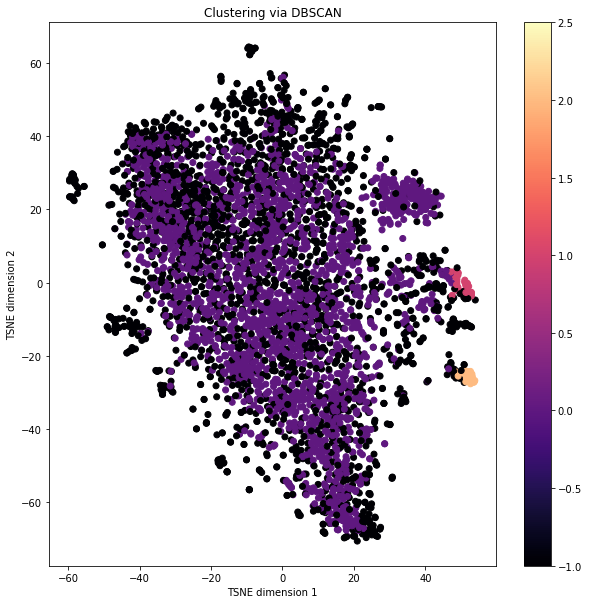

In [202]:
pl.figure(figsize=(10,10))

pl.scatter(twodproj[:,0], twodproj[:,1],  c=(labels), cmap='magma', vmax=2.5)
pl.colorbar()
pl.title("Clustering via DBSCAN")
pl.xlabel("TSNE dimension 1")
pl.ylabel("TSNE dimension 2")
None;

**Figure 6** After what felt to be a very thorough exploration of the hyperparameter space (see the loop commented out above the figure), the best breakdown that I could really find was the above, or similar. There was usually either a very large amount of points classified as noise, or just one very large cluster, and occasionally a few very small fringe clusters.

This plot does show some of the higher dimensionality of the dataset, but the high quantity of noise (1934 of 4224) makes this clustering less useful.

Cluster "-1" is noise, and clusters "0-2" are clusters found by the algorithm.

---

This result leads us to believe that this algorithm is not well suited to clustering this dataset. This may be due to the high-dimensionality of the dataset (74 dimensions).

In [19]:
labels = dbs.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_clusters_, n_noise_

(3, 1934)

# 4b (667)

In [0]:
sp.cluster.hierarchy.set_link_color_palette(['C0','C1','C2','C3','C4','C5'])

In [0]:
links_gene = linkage(genes_scaled, method='ward')

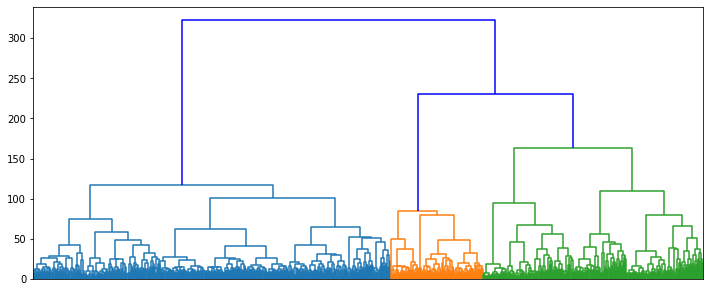

In [217]:
pl.figure(figsize=(12,5))
dendrogram(links_gene, p=10, truncate_mode='level', no_labels=True);

**Figure 7** Dendrogram of Ward-Agglomerative-Clustering of the data. The Ward algorithm minimizes the intracluster variance at each step. Three clusters are clearly shown in the data.

In [0]:
links_gene_2 = linkage(genes_scaled, method = 'complete')

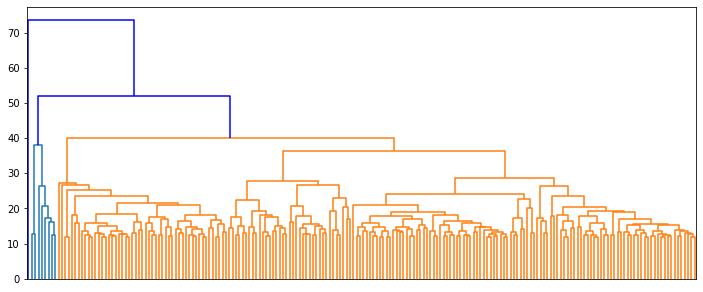

In [216]:
pl.figure(figsize=(12,5))
dendrogram(links_gene_2, p=10, truncate_mode='level', no_labels=True);

**Figure 8** A similar dendrogram, now using the 'complete' distance metric: the distance between two clusters was calculated using the maximum distance between two elements of those clusters.

312576.00000000006
265786.21130934544
240649.59622656365
240557.2366028278
239961.49171955144
235074.38528557075
234083.16084309437
232028.39531397203
228615.8484280025
228470.48992579285


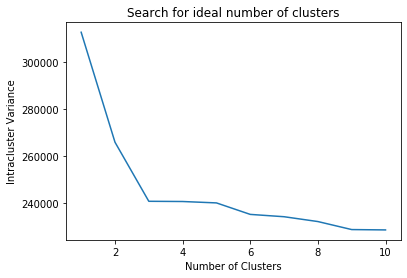

In [219]:
tv_ag = []

np.random.seed(180135)

for i in range(1, 11):
    agger = skl.cluster.AgglomerativeClustering(n_clusters = i).fit(
        genes_scaled)
    km = agger.labels_
    tv_ag.append(CalICVar(genes_scaled, agger.labels_))

pl.plot(range(1,11), tv_ag)
pl.title("Search for ideal number of clusters")
pl.xlabel("Number of Clusters")
pl.ylabel("Intracluster Variance")

None;

**Figure 9** Searching for an 'elbow' in the plot, indicating ideal number of clusters using a Ward-agglomerative-clustering algorithm. Again,in this case it seems fairly clear that 3-clusters is a good choice.

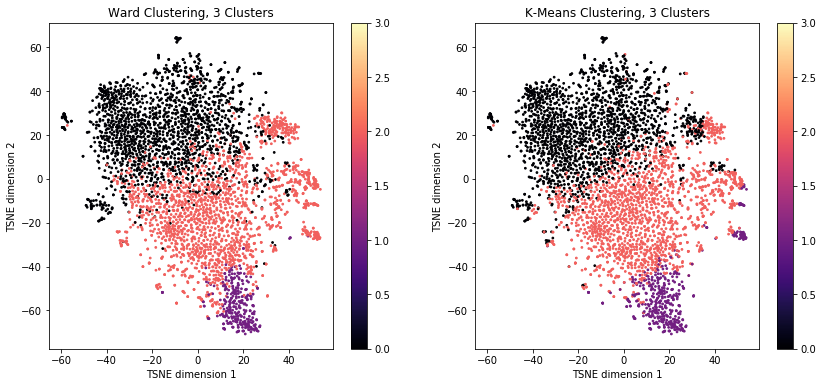

In [220]:
genes_agcluster = skl.cluster.AgglomerativeClustering(n_clusters=3).fit(
    genes_scaled)

pl.figure(figsize=(14,6))
pl.subplot(121)
sizee = 3
pl.scatter(twodproj[:,0], twodproj[:,1], c=(genes_agcluster.labels_+2)%3,
           s=sizee, cmap='magma', vmax = 3)
pl.title('Ward Clustering, 3 Clusters')
pl.xlabel("TSNE dimension 1")
pl.ylabel("TSNE dimension 2")
pl.colorbar()
pl.subplot(122)
pl.scatter(twodproj[:,0], twodproj[:,1], c=(genes_kmclust.labels_), s=sizee,
           cmap='magma', vmax = 3)
pl.title('K-Means Clustering, 3 Clusters')
pl.xlabel("TSNE dimension 1")
pl.ylabel("TSNE dimension 2")
pl.colorbar();

**Figure 10** A comparison of the clusters found using k-means and ward clustering. The general locations and sizes of the clusters was relatively the same, while the boundaries between clusters varied for the two algorithms. Most noticeably, some of the outer 'islands' of datapoints are calssified much differently depending on the algorithm used (see the high-dimension-1 groups near -20<dimension2<0)